In [18]:
from ml_pipeline import forecasting_pipeine
from helpers.utils import read_csv
from helpers.ml import MAPE
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import gc
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sales = read_csv(r'../data/sales.csv')
taxonomy = read_csv(r'../data/product_taxonomy.csv')
stores = read_csv(r'../data/store_cities.csv')

Mem. usage decreased from 8412.51 Mb to 8004.33 Mb (4.9% reduction)
Mem. usage decreased from  0.31 Mb to  0.31 Mb (2.6% reduction)
Mem. usage decreased from  0.03 Mb to  0.03 Mb (3.6% reduction)


In [3]:
data = pd.merge(sales, taxonomy, how='inner', on = ['product_id'])\
         .merge(stores, how='inner', on = ['store_id'])

In [4]:
del sales, taxonomy, stores
gc.collect()

62

# Create predictions

We need to make daily forecasting for October 2019

Baselines

- average YoY sales based on seasonality (average sales by same dates in previous years multiplied by YoY trend)
- Facebook Prophet

Model (LightGBM model with recursive prediction schema)

- Recursive approach is based on using predictions as features for new predictions. E. g. we predicted sales for January 1st to use this prediction as a feature for January 2nd


In [5]:
prediction_end_dates = pd.date_range(datetime.datetime(
    2019, 5, 1), datetime.datetime(2019, 11, 1), freq='M')
results = pd.DataFrame()

# prediction_end_dates = pd.date_range(datetime.datetime(
#     2017, 3, 1), datetime.datetime(2017, 4, 1), freq='M')
# results = pd.DataFrame()


for prediction_end_date in prediction_end_dates:

    train_start_date = datetime.datetime(2017, 1, 1)

    test_start_date = prediction_end_date - \
        relativedelta(months=2) + relativedelta(days=1)

    prediction_start_date = prediction_end_date - \
        relativedelta(months=1) + relativedelta(days=1)
    test_end_date = prediction_start_date - relativedelta(days=1)

    train_end_date = test_start_date - relativedelta(days=1)

    print('')
    print(f'''Forecasting for parameters:''')
    print(
        f'''Training range: {train_start_date.date()}, {train_end_date.date()}''')
    print(
        f'''Validation range: {test_start_date.date()}, {test_end_date.date()}''')
    print(
        f'''Prediction range: {prediction_start_date.date()}, {prediction_end_date.date()}''')

    cfg = {}
    cfg['MODEL'] = \
        {
        "train_start_date": train_start_date, "train_end_date": train_end_date,
        "test_start_date": test_start_date, "test_end_date": test_end_date,
        "prediction_start_date": prediction_start_date, "prediction_end_date": prediction_end_date
    }

    prediction_results = forecasting_pipeine(data[data.date.between(str(train_start_date)[:10],
                                                                    str(prediction_end_date)[
                                                                        :10])
                                                  ], cfg, output_predictions=False)

    prediction_results['prediction_period'] = prediction_end_date

    for score_name, model_name in zip(['lgb_predicted', 'predicted_seasonal_average', 'predicted_fbprophet'],
                                      ['LGB', 'Average YoY', 'FBProphet']):

        print('MAPE by {0} model : {1:0.1} %'.format(model_name, MAPE(
            prediction_results['sales'], prediction_results[score_name])))

    results = results.append(prediction_results, ignore_index=True)
    results.to_csv(r'../output/results.csv', index=False)



Forecasting for parameters:
Training range: 2017-01-01, 2019-03-31
Validation range: 2019-04-01, 2019-04-30
Prediction range: 2019-05-01, 2019-05-31
Expected number of predicitons: 496
Processing feature: promo_type_1
Processing feature: promo_bin_1
Processing feature: promo_type_2
Processing feature: promo_bin_2
Processing feature: promo_discount_2
Processing feature: promo_discount_type_2
Processing feature: city_id
Processing feature: cluster_id
Started building LightGBM model...
Categorical columns for target encoding: 2
['hierarchy1_id', 'storetype_id']
Train data shape: NROWS = 12530, NCOLUMNS = 119
Validation data shape: NROWS = 475, NCOLUMNS = 119
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
LGB model trained!
Recurisely predicted date: str(2019-05-02 00:00:00)
Recurisely predicted date: str(2019-05-03 00:00:00)
Recurisely predicted date: str(2019-05-04 00:00:00)
Recurisely predicted date: str(2019-05

# Compare LightGBM model against baselines by WMAPE (Weighted MAPE)

In [68]:
results = pd.read_csv(r'../output/results.csv')
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
prediction_pairs = results[['hierarchy1_id', 'storetype_id']].drop_duplicates()

In [69]:
results.iloc[:, -5:-1].sum()

sales                         1.434128e+06
lgb_predicted                 1.310042e+06
predicted_seasonal_average    7.325608e+05
predicted_fbprophet           1.381326e+06
dtype: float64

In [70]:
results['weight'] = results['sales'] / results.groupby(['date'])['sales'].sum()
results['weight'] = results['sales'] / results['date'].map(results.groupby(['date'])['sales'].sum() + 1)

In [71]:
# Filter only product categories with > 1% of sales
results = results[results.weight > 0.01]

In [72]:
score_cols = []
for score_name, model_score in zip(['LGB', 'FB Prophet', 'Seasonal YoY Average'], ['lgb_predicted', 'predicted_fbprophet', 'predicted_seasonal_average']):
    results['MAPE by %s' % score_name] = results['weight']*100*abs(
        results[model_score] - results['sales']) / (results['sales'] + 1)
    score_cols.append('MAPE by %s' % score_name)

In [73]:
score_cols = []
for score_name, model_score in zip(['LGB', 'FB Prophet', 'Seasonal YoY Average'], ['lgb_predicted', 'predicted_fbprophet', 'predicted_seasonal_average']):
    results['MAPE by %s' % score_name] = 100*abs(
        results[model_score] - results['sales']) / (results['sales'] + 1)
    score_cols.append('MAPE by %s' % score_name)


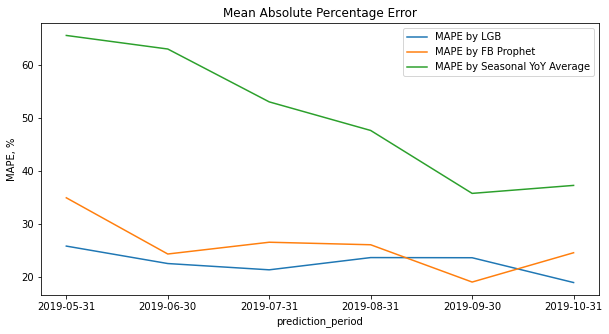

In [74]:

results.groupby(['prediction_period'])[score_cols].mean().plot(figsize=(10,5))
plt.title("Mean Absolute Percentage Error")
plt.ylabel('MAPE, %')
# plt.show()
plt.savefig('performance.png')

In [75]:
results.groupby(['hierarchy1_id', 'storetype_id'])[score_cols].mean().round(1)

MAPE by LGB  MAPE by FB Prophet  \
hierarchy1_id storetype_id                                    
H00           ST01                 20.4                21.0   
              ST02                 13.5                14.0   
              ST03                 14.0                14.9   
              ST04                 11.0                11.9   
H01           ST01                 25.2                29.5   
              ST03                 36.3                39.0   
              ST04                 26.4                27.9   
H02           ST04                 64.6                73.7   
H03           ST01                 25.2                27.3   
              ST03                 37.4                45.9   
              ST04                 24.6                33.4   

                            MAPE by Seasonal YoY Average  
hierarchy1_id storetype_id                                
H00           ST01                                  43.1  
              ST02                                  48.9  
              ST03                                  49.0  
              ST04                                  46.3  
H01           ST01                                  45.9  
              ST03                                  61.9  
              ST04                                  48.1  
H02           ST04                                  54.9  
H03           ST01                                  53.4  
              ST03                                  58.3  
              ST04                                  53.8

In [76]:
results[results.weight > 0.01].groupby(['hierarchy1_id', 'storetype_id'])[score_cols].mean().round(1)

MAPE by LGB  MAPE by FB Prophet  \
hierarchy1_id storetype_id                                    
H00           ST01                 20.4                21.0   
              ST02                 13.5                14.0   
              ST03                 14.0                14.9   
              ST04                 11.0                11.9   
H01           ST01                 25.2                29.5   
              ST03                 36.3                39.0   
              ST04                 26.4                27.9   
H02           ST04                 64.6                73.7   
H03           ST01                 25.2                27.3   
              ST03                 37.4                45.9   
              ST04                 24.6                33.4   

                            MAPE by Seasonal YoY Average  
hierarchy1_id storetype_id                                
H00           ST01                                  43.1  
              ST02                                  48.9  
              ST03                                  49.0  
              ST04                                  46.3  
H01           ST01                                  45.9  
              ST03                                  61.9  
              ST04                                  48.1  
H02           ST04                                  54.9  
H03           ST01                                  53.4  
              ST03                                  58.3  
              ST04                                  53.8

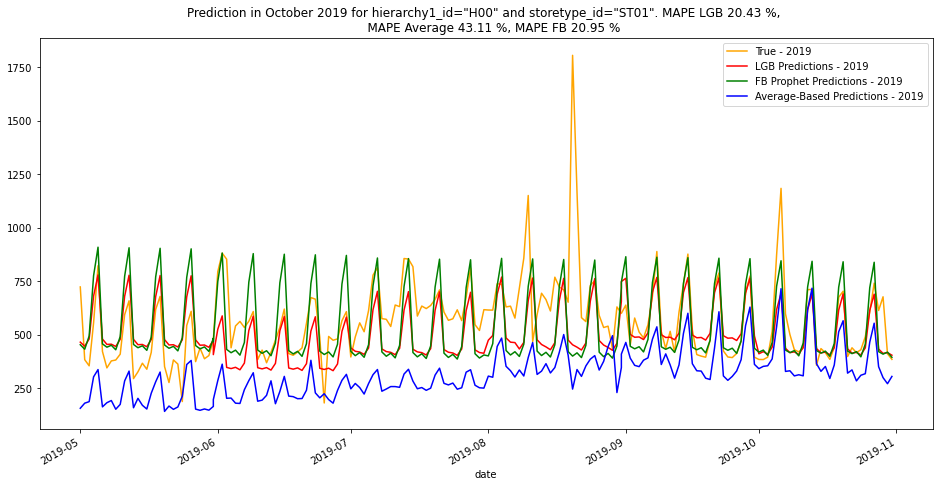

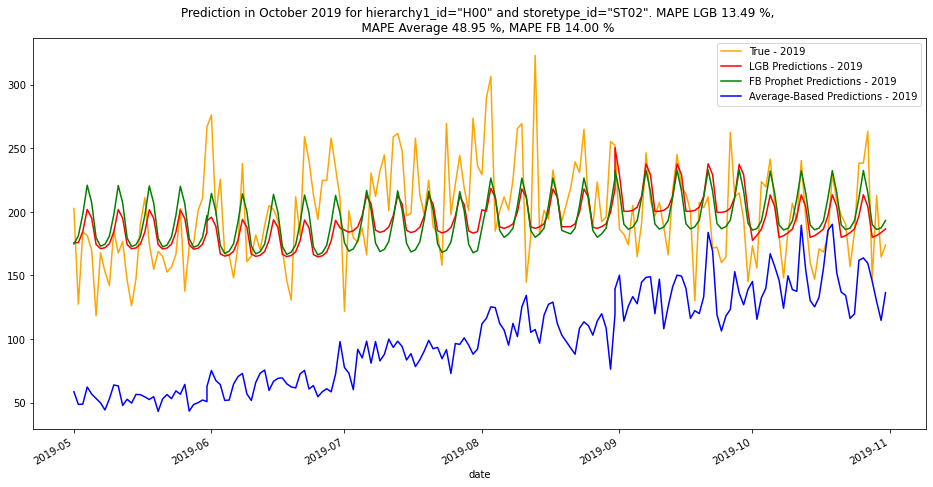

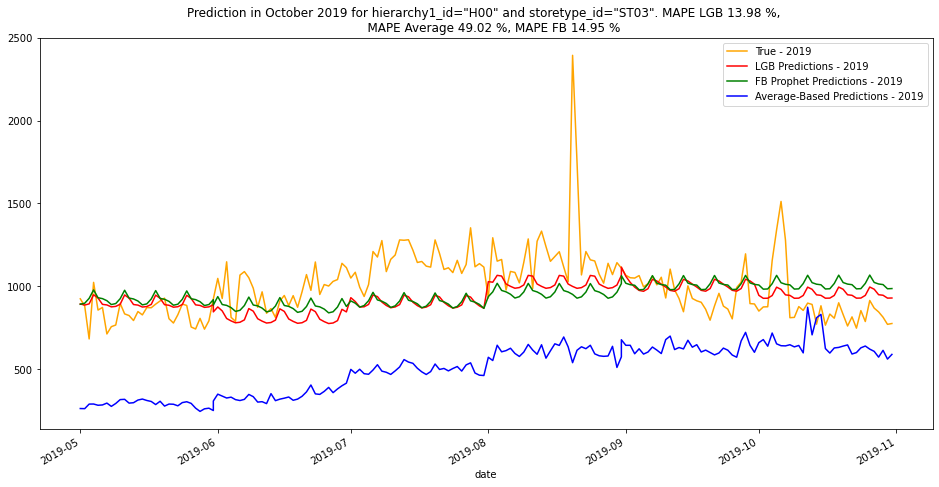

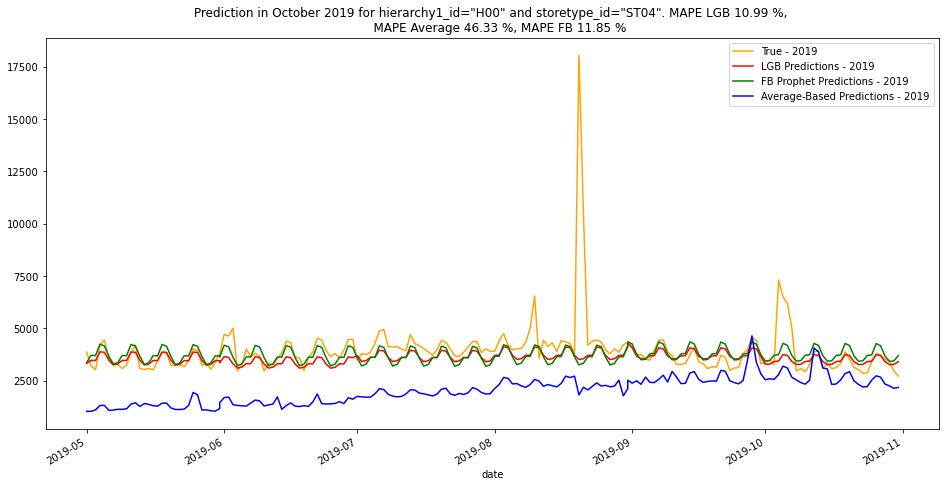

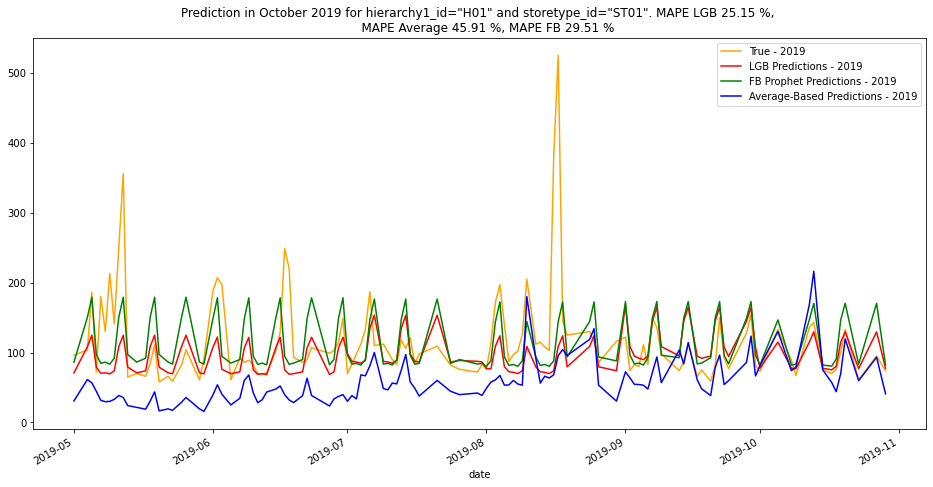

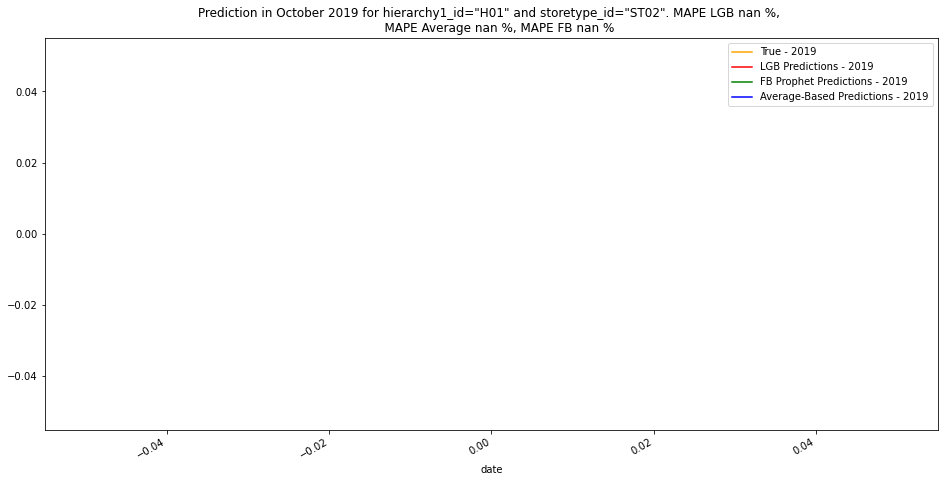

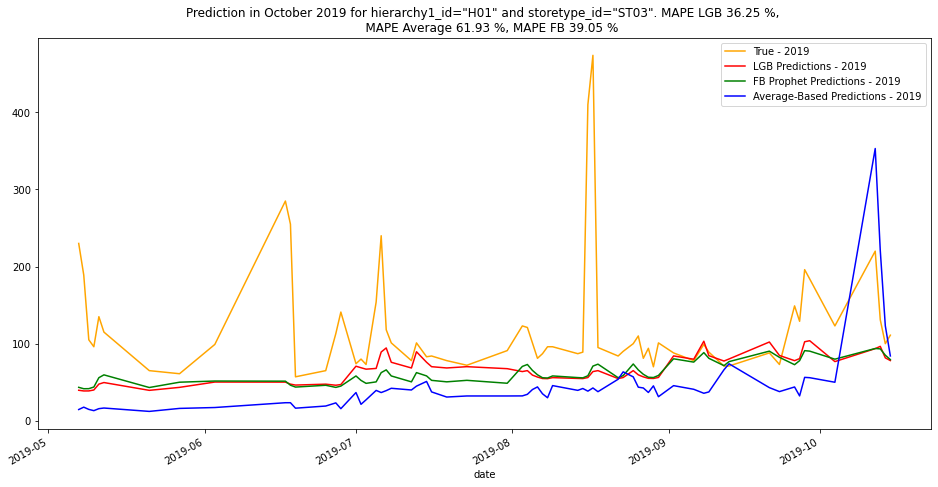

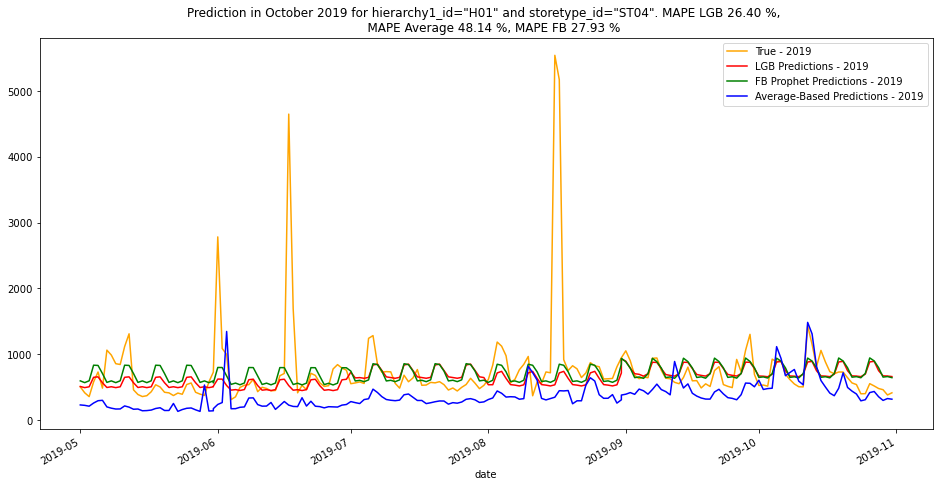

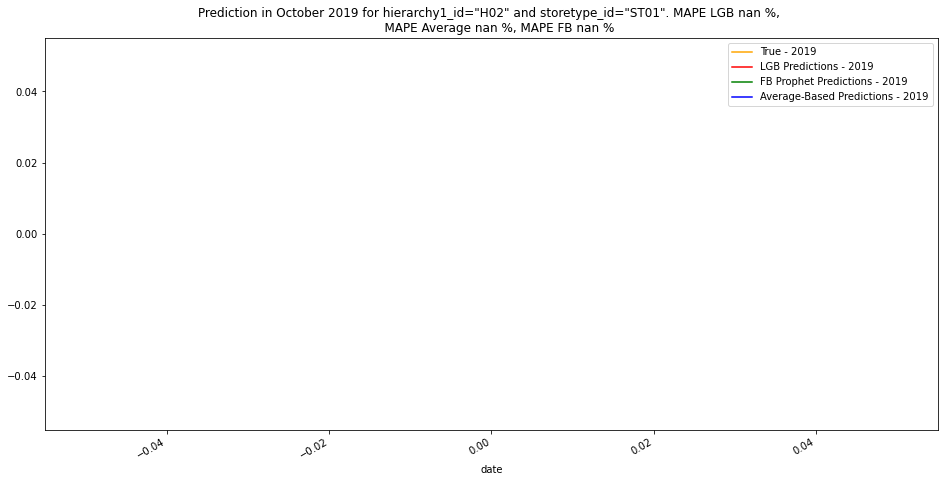

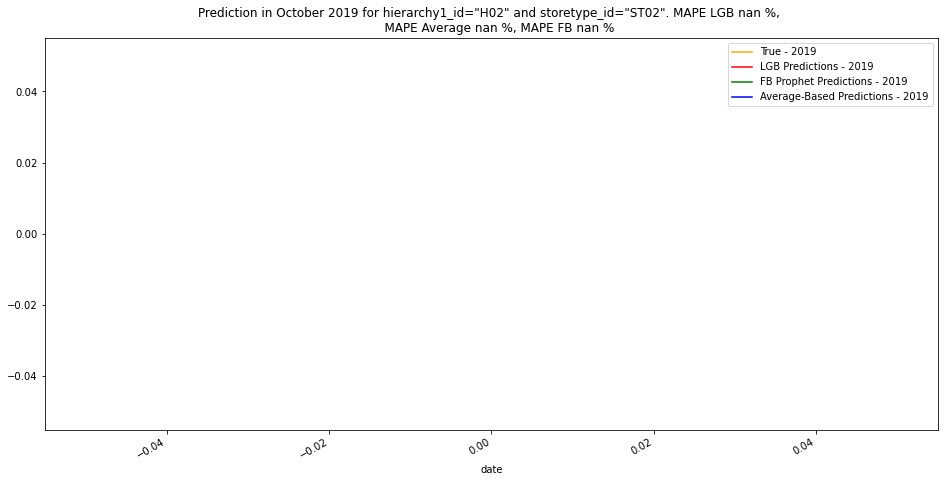

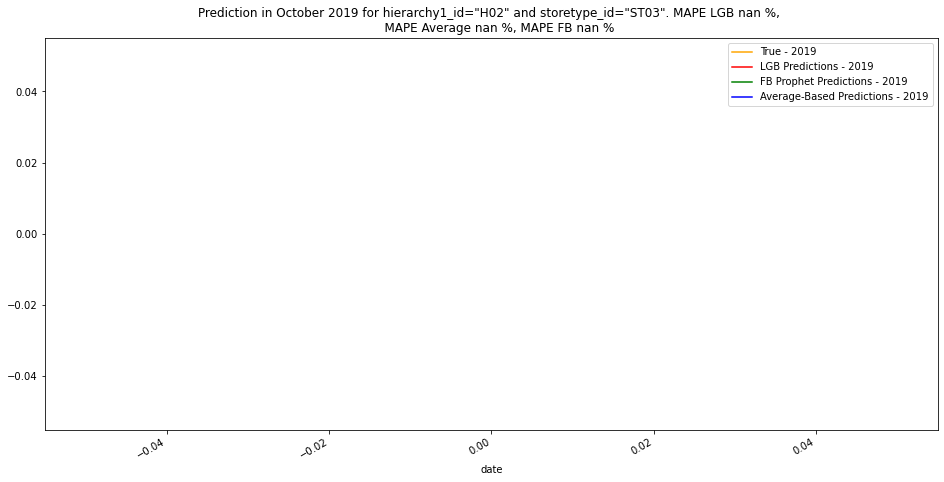

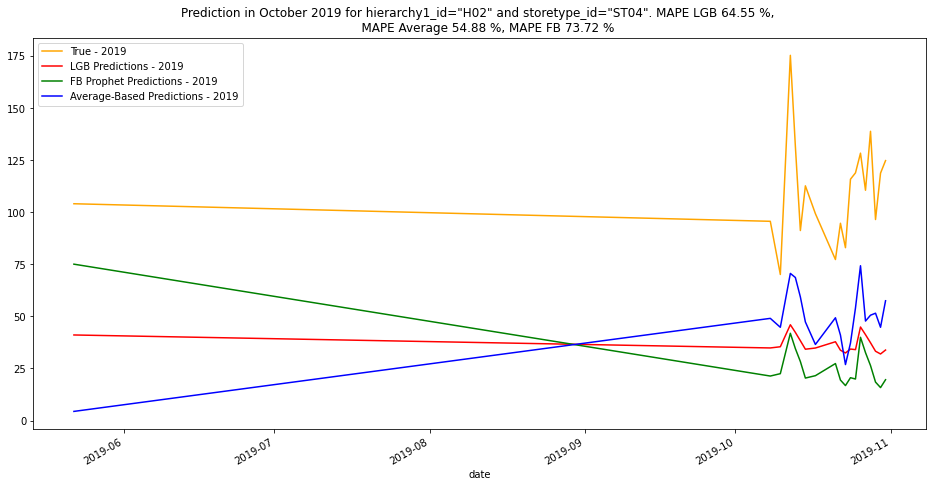

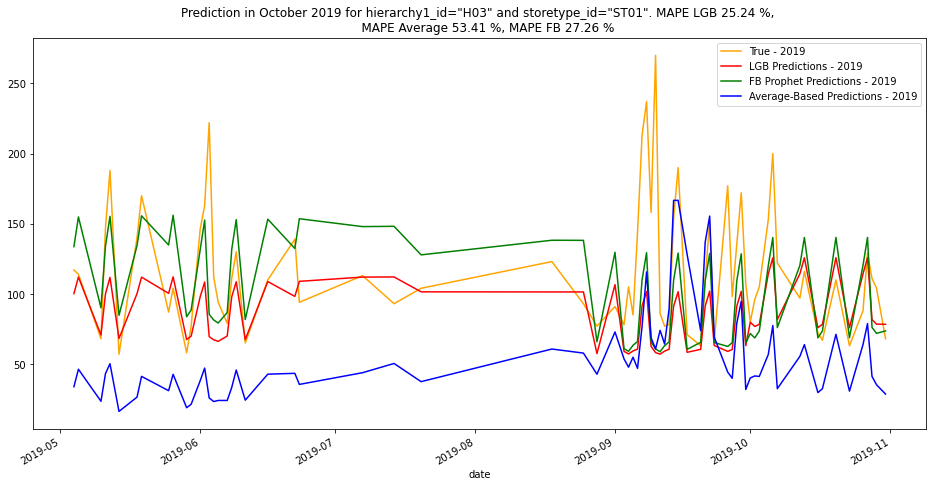

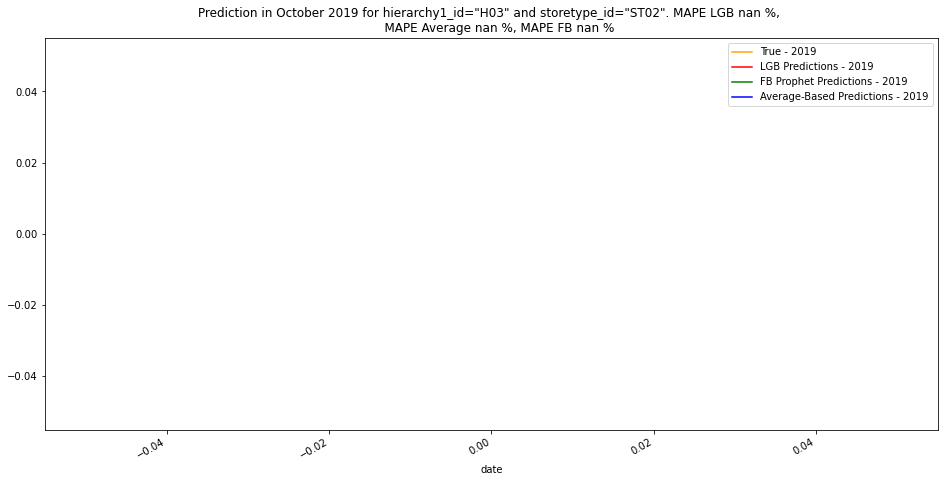

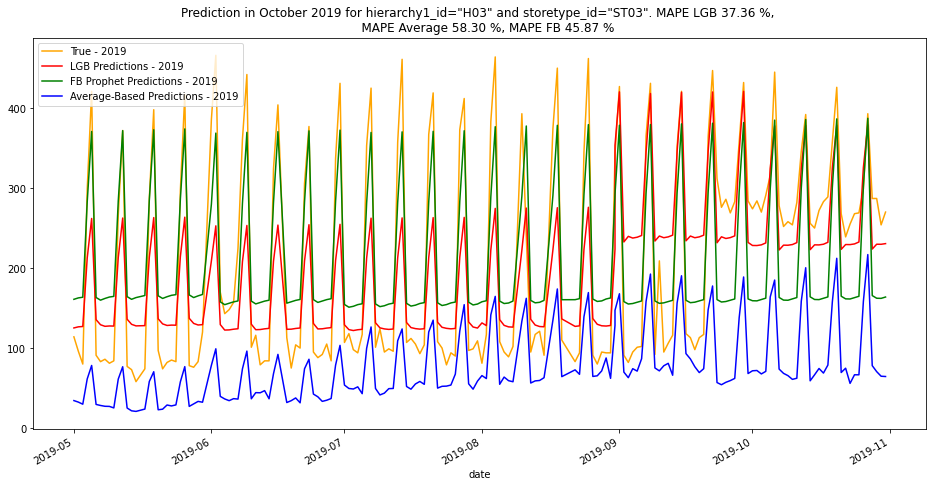

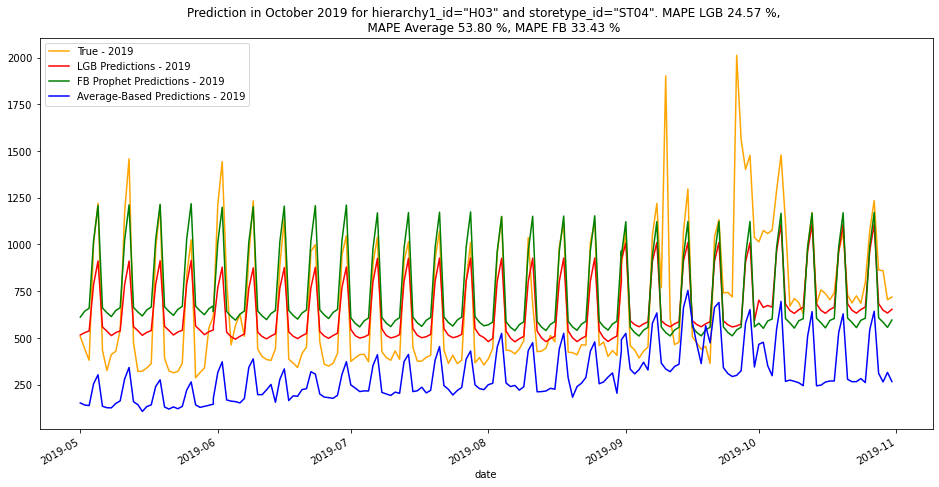

In [59]:
for pair in prediction_pairs.to_numpy():
    results[(results.hierarchy1_id == pair[0]) &
            (results.storetype_id == pair[1])].set_index('date')['sales'].plot(figsize=(16, 8), label='True - 2019', c='orange')
    results[(results.hierarchy1_id == pair[0]) &
            (results.storetype_id == pair[1])].set_index('date')['lgb_predicted'].plot(figsize=(16, 8), label='LGB Predictions - 2019', c='red')
    results[(results.hierarchy1_id == pair[0]) &
            (results.storetype_id == pair[1])].set_index('date')['predicted_fbprophet'].plot(figsize=(16, 8), label='FB Prophet Predictions - 2019', c='green')
    results[(results.hierarchy1_id == pair[0]) &
            (results.storetype_id == pair[1])].set_index('date')['predicted_seasonal_average'].plot(figsize=(16, 8), label='Average-Based Predictions - 2019', c='blue')


    mape_lgb = \
        MAPE(results[(results.hierarchy1_id == pair[0]) &
                     (results.storetype_id == pair[1])]['sales'], results[(results.hierarchy1_id == pair[0]) &
                                                                          (results.storetype_id == pair[1])]['lgb_predicted'])

    mape_fb = \
        MAPE(results[(results.hierarchy1_id == pair[0]) &
                     (results.storetype_id == pair[1])]['sales'], results[(results.hierarchy1_id == pair[0]) &
                                                                          (results.storetype_id == pair[1])]['predicted_fbprophet'])

    mape_avg = \
        MAPE(results[(results.hierarchy1_id == pair[0]) &
                     (results.storetype_id == pair[1])]['sales'], results[(results.hierarchy1_id == pair[0]) &
                                                                          (results.storetype_id == pair[1])]['predicted_seasonal_average'])


    plt.title('''Prediction in October 2019 for hierarchy1_id="{0}" and storetype_id="{1}". MAPE LGB {2:0.2f} %, 
    MAPE Average {3:0.2f} %, MAPE FB {4:0.2f} %'''
              .format(pair[0], pair[1], mape_lgb, mape_avg, mape_fb))

    plt.legend()
    plt.show()
